# Project 3: Modeling Time Series Data with RNN

For this project we will use the Electronic Health Records (EHRs) dataset

## Part 1: Data Preparation

In [2]:
import numpy as np
import pandas as pd

### 1.1 Loading the data

In [3]:
# Loading the data

x_train = pd.read_hdf('/Users/bryanmonca/Workspace/cmsi-634/Project3/Data/X_train.hdf')
x_test = pd.read_hdf('/Users/bryanmonca/Workspace/cmsi-634/Project3/Data/X_test.hdf')

y_train = pd.read_hdf('/Users/bryanmonca/Workspace/cmsi-634/Project3/Data/y_train.hdf')
y_test = pd.read_hdf('/Users/bryanmonca/Workspace/cmsi-634/Project3/Data/y_test.hdf')

We have loaded the dataset divided in 4 different parts. A training and testing set of the data, and a training and testing set with the labels

Let's investigate the training data a little bit

In [4]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1113529 entries, (8, 0.0) to (16259, 89.0)
Columns: 265 entries, ABG Base excess (mEq/L) to deltat
dtypes: float32(1), float64(264)
memory usage: 2.2 GB


In [5]:
x_train

ABG Base excess (mEq/L)  ABG FiO2  ABG HCO3 (mEq/L)  \
encounterID absoluteTime                                                        
8           0.000000                          NaN       NaN               NaN   
            0.250000                          NaN       NaN               NaN   
            0.500000                          NaN       NaN               NaN   
            0.583333                          NaN       NaN               NaN   
            0.750000                          NaN       NaN               NaN   
...                                           ...       ...               ...   
16259       87.000000                         NaN       NaN               NaN   
            87.083336                         NaN       NaN               NaN   
            87.666664                         NaN       NaN               NaN   
            88.000000                         NaN       NaN               NaN   
            89.000000                         NaN       NaN               NaN   

                          ABG O2 sat (%)  ABG PCO2 (mmHg)  ABG PO2 (mmHg)  \
encounterID absoluteTime                                                    
8           0.000000                 NaN              NaN             NaN   
            0.250000                 NaN              NaN             NaN   
            0.500000                 NaN              NaN             NaN   
            0.583333                 NaN              NaN             NaN   
            0.750000                 NaN              NaN             NaN   
...                                  ...              ...             ...   
16259       87.000000                NaN              NaN             NaN   
            87.083336                NaN              NaN             NaN   
            87.666664                NaN              NaN             NaN   
            88.000000                NaN              NaN             NaN   
            89.000000                NaN              NaN             NaN   

                          ABG TCO2 (mEq/L)  ABG pH  ALT (SGPT) (units/L)  \
encounterID absoluteTime                                                   
8           0.000000                   NaN     NaN                   NaN   
            0.250000                   NaN     NaN                   NaN   
            0.500000                   NaN     NaN                   NaN   
            0.583333                   NaN     NaN                   NaN   
            0.750000                   NaN     NaN                   NaN   
...                                    ...     ...                   ...   
16259       87.000000                  NaN     NaN                   NaN   
            87.083336                  NaN     NaN                   NaN   
            87.666664                  NaN     NaN                   NaN   
            88.000000                  NaN     NaN                   NaN   
            89.000000                  NaN     NaN                   NaN   

                          AST (SGOT) (units/L)  ...  Vasopressin  Vecuronium  \
encounterID absoluteTime                        ...                            
8           0.000000                       NaN  ...          NaN         NaN   
            0.250000                       NaN  ...          NaN         NaN   
            0.500000                       NaN  ...          NaN         NaN   
            0.583333                       NaN  ...          NaN         NaN   
            0.750000                       NaN  ...          NaN         NaN   
...                                        ...  ...          ...         ...   
16259       87.000000                      NaN  ...          NaN         NaN   
            87.083336                      NaN  ...          NaN         NaN   
            87.666664                      NaN  ...          NaN         NaN   
            88.000000                      NaN  ...          NaN         NaN   
            89.000000

In [6]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1113529 entries, (8, 0.0) to (16259, 89.0)
Data columns (total 1 columns):
 #   Column             Non-Null Count    Dtype
---  ------             --------------    -----
 0   mortalityResponse  1113529 non-null  int64
dtypes: int64(1)
memory usage: 18.1 MB


In [7]:
y_train

mortalityResponse
encounterID absoluteTime                   
8           0.000000                      1
            0.250000                      1
            0.500000                      1
            0.583333                      1
            0.750000                      1
...                                     ...
16259       87.000000                     1
            87.083336                     1
            87.666664                     1
            88.000000                     1
            89.000000                     1

[1113529 rows x 1 columns]

The whole dataset is a multi-index dataframe, where index level 0 is the unique patient encounter identifier and index level 1 is the time of each measurements in units of hours since first measurement.

In [8]:
# Index numbers and names

print(x_train.index.nlevels) # index numbers
print(x_train.index.names) # index names

2
['encounterID', 'absoluteTime']


### 1.2 Number of patients, timestamps, and types of measurements

Let's calculate the unique number of patiens, and the unique number of timestamps measured

In [9]:
x_train.index.levshape

(5000, 76693)

There are 5000 encounterID's and 76,693 timestamps measured in total.

In [10]:
# Shape
x_train.shape

(1113529, 265)

In addition, we have in total 1,113,529 observations in our dataset, and we have 265 types of measurements.

### 1.3 Measurements taken by patient

We can see for each patient encounter how many time measurements there are. Remember the dataset has 5,000 different patient encounters. We will check for some some patients, the patients measurements.

In [11]:
# Number of time measurements by patient ordered by encounterID
x_train.groupby(level=0).size()

encounterID
8        439
11        84
13        49
15        43
18       666
        ... 
16248    118
16250    118
16254    104
16255     91
16259    231
Length: 5000, dtype: int64

In [12]:
# Number of time measurements by patient ordered by encounterID
# First 10 (sorted by encounterID)

x_train.groupby(level=0).size().head(10)

encounterID
8     439
11     84
13     49
15     43
18    666
20    376
21    108
23    125
25     65
27     47
dtype: int64

In [13]:
# Number of time measurements by patient ordered by number of timestamps
# First 10 (sorted by number of timestamps)

x_train.groupby(level=0).size().sort_values(ascending=False).head(10)

encounterID
15983    13127
9163      4738
11928     4683
5493      4669
605       4206
15695     4013
14321     3881
2599      3835
6474      3622
12770     3428
dtype: int64

Maximum length of patient timestamps is 13,127

In [14]:
# Number of time measurements by patient ordered by number of timestamps
# Last 10 (sorted by number of timestamps)

x_train.groupby(level=0).size().sort_values(ascending=False).tail(10)

encounterID
15929    17
9171     17
8883     17
15313    17
7866     17
15491    16
6662     16
15322    16
4146     15
11270    15
dtype: int64

The smallest number of patient timestamps is 15

After sorting and checking, the first 10 and last 10 encounter ID's, we find that the number of time measurements per patient varies a lot. We can understand these differences better by plotting them:

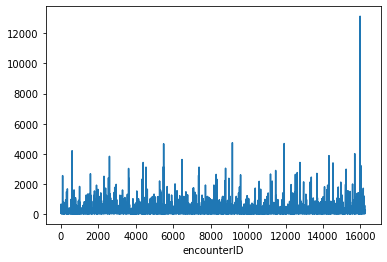

In [15]:
x_train.groupby(level=0).size().plot()

We can check in more detailed how different are the number of time measurements for each of the Encounter ID. As we saw, the maximum number of time measurements for a Encounter ID is 13,127, the next one is 4,738, and the minimum is only 15 values. At the same time, we can appreciate that most of the lengths per encounterID are under around 1000.

### 1.4 Data Normalization

Because most of the variables have different scale, it is necessary to normalize the data

In [19]:
#Data normalization
mean = x_train.mean(axis=0)
x_train -= mean
std = x_train.std(axis=0)
x_train /= std

x_test -= mean
x_test /= std

### 1.5 Examining and Filling in missing data

Until now we have noticed how different each encounter ID is, some have more data than others. However, we have not talked about missing data. 

In [20]:
np.sum(pd.isnull(x_train), axis = 0).sum()

284410810

There are 284,410,810 missing data points, but remember the data counts with 1,113,529 observations, 265 types of measurements, and it counts with data of 5,000 different patients with different timestamps. We could use information from previous timestamps measurements to fill in more recent ones.

In [21]:
np.sum(pd.isnull(x_train), axis=0).head(20)

ABG Base excess (mEq/L)    1095394
ABG FiO2                   1105870
ABG HCO3 (mEq/L)           1095388
ABG O2 sat (%)             1095401
ABG PCO2 (mmHg)            1095323
ABG PO2 (mmHg)             1095277
ABG TCO2 (mEq/L)           1095442
ABG pH                     1095282
ALT (SGPT) (units/L)       1103027
AST (SGOT) (units/L)       1103031
Abdominal girth (cm)       1108485
Acetaminophen              1113529
Acetaminophen/Codeine      1113529
Acetazolamide              1113529
Acetylcysteine             1113529
Acyclovir                  1113529
Age                              0
Albumin                    1113529
Albumin level (g/dL)       1102850
Albuterol                  1113529
dtype: int64

Depending on the variable, we could see a lot of missing values, however, variables such as age are without null values.

In [22]:
(np.sum(pd.isnull(x_train), axis=0) < 1000000).sum()

19

In [23]:
(np.sum(pd.isnull(x_train), axis=0) < 500000).sum()

5

If we filter out columns with missing values less than 1 million, we have 19 columns from the 265. This could be due that there not records for every timestep.

In [24]:
x_train.describe()

,ABG Base excess (mEq/L),ABG FiO2,ABG HCO3 (mEq/L),ABG O2 sat (%),ABG PCO2 (mmHg),ABG PO2 (mmHg),ABG TCO2 (mEq/L),ABG pH,ALT (SGPT) (units/L),AST (SGOT) (units/L),...,Vasopressin,Vecuronium,Ventilator rate (bpm),VerbalResponse,Vitamin E,Volume Tidal,Voriconazole,Weight,White blood cell count (K/uL),deltat
count,1.813500e+04,7.659000e+03,1.814100e+04,1.812800e+04,1.820600e+04,1.825200e+04,1.808700e+04,1.824700e+04,1.050200e+04,1.049800e+04,...,0.0,0.0,2.090590e+05,2.726040e+05,0.0,2.453500e+04,0.0,6.814300e+04,2.350900e+04,1.113529e+06
mean,1.865003e-16,1.218216e-16,-2.600741e-16,2.104818e-16,2.207030e-16,-8.097353e-17,-9.428333e-18,4.049202e-14,9.641244e-18,-1.336752e-17,...,NaN,NaN,8.157040e-17,-7.548428e-17,NaN,-2.532700e-14,NaN,1.013110e-14,1.847308e-15,1.359918e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,NaN,NaN,1.000000e+00,1.000000e+00,NaN,1.000000e+00,NaN,1.000000e+00,1.000000e+00,1.000000e+00
min,-4.465112e+00,-2.157610e+00,-3.759418e+00,-1.189077e+01,-3.170992e+00,-1.699680e+00,-3.810244e+00,-8.286609e+00,-3.297174e-01,-2.643052e-01,...,NaN,NaN,-2.552642e+00,-9.931693e-01,NaN,-4.997278e+00,NaN,-9.347872e-01,-5.257699e-01,-1.376004e+00
25%,-6.381594e-01,-6.425480e-01,-6.662800e-01,-9.244274e-02,-5.951552e-01,-6.170285e-01,-6.969435e-01,-4.561868e-01,-2.920339e-01,-2.363979e-01,...,NaN,NaN,-7.945393e-01,-9.931693e-01,NaN,-6.036989e-01,NaN,-7.378719e-01,-2.514104e-01,-9.233640e-01
50%,-7.706487e-02,-4.197448e-01,-1.038912e-01,2.840997e-01,-1.884440e-01,-2.495090e-01,-1.555000e-01,1.167702e-01,-2.573652e-01,-2.127189e-01,...,NaN,NaN,1.521313e-01,-4.625166e-01,NaN,-1.681638e-02,NaN,-4.335483e-01,-9.824033e-02,-1.086123e-01
75%,5.991260e-01,4.714679e-01,5.990947e-01,5.351279e-01,3.538375e-01,3.630235e-01,5.213044e-01,5.942338e-01,-1.428074e-01,-1.382993e-01,...,NaN,NaN,6.930860e-01,1.129442e+00,NaN,5.941846e-01,NaN,5.062745e-01,8.522708e-02,1.294571e+00
max,6.756779e+00,2.253893e+00,9.737911e+00,6.606421e-01,1.302967e+01,9.321311e+00,6.341823e+00,3.745503e+00,1.775383e+01,1.857316e+01,...,NaN,NaN,6.914065e+00,1.129442e+00,NaN,9.526054e+00,NaN,7.174541e+00,3.078025e+01,9.396824e+00


We are going to treat the missing data as follows: for each patient encounter, we fill in missing data using forward filling. This solution helps because consecutive timesteps might have the same measurements. In addition, if there was not a previous measurement, we fill in missing data by zeros.

In [25]:
# Fill in missing data with forward filling and zeros

x_train = x_train.groupby(level=0).fillna(method='ffill')
x_train = x_train.fillna(0)

### 1.6 Setting maximum length for all sequences

Now, we are going to set the maximum length of sequence for all the patients encounter to the 90 percentile of all the lengths, and we are going to truncate or zero-pad to the same maximum length for all
patient encounter sequences using a numpy array. Let's first do all of this for the training set. 

To make things easier, we will create a dataframe with the length of each group, then, we will calculate the 90th percentile of the lengths

In [26]:
# Sorting the indexes at level 0
x_train = x_train.sort_index(level=0)

# Creating a dataframe with the length for each group
groups_lengths = x_train.reset_index().iloc[:,0].value_counts().to_frame().reset_index()

In [27]:
# Renaming some column names
groups_lengths = groups_lengths.rename(columns={"encounterID":"length","index": "encounterID"})
groups_lengths = groups_lengths.sort_values(by=['encounterID']).reset_index().iloc[:,1:]
groups_lengths

,encounterID,length
0,8,439
1,11,84
2,13,49
3,15,43
4,18,666
...,...,...
4995,16248,118
4996,16250,118
4997,16254,104
4998,16255,91


We got the length/timestamps number for each patient

In [28]:
# Calculating 90th percentile of encounterID lengths
np.percentile(groups_lengths.iloc[:,1], 90)

523.1000000000004

The 90th percentile of the length of all groups is 523.10, however, to work with an easier number we will use 500 (maxlen). This number will be number of timestamps for each of the 5,000 patients

In [29]:
# Setting max length
maxlen = 500
maxlen

500

We will define a function to transform our x_train dataframe into a 3d-numpy array.

In [30]:
samples = np.zeros((len(groups_lengths), maxlen, x_train.shape[-1]))
def gen_x(samples, x_train, groups_lengths, maxlen): 
    for i, elem in enumerate(groups_lengths['encounterID']):
        max_length_elem = groups_lengths.iloc[i,1] #max lengths
        if (max_length_elem >= maxlen): # Truncate
            samples[i, :maxlen, :] = x_train.loc[elem].iloc[:maxlen]
        elif (max_length_elem < maxlen): # Padding
            samples[i, :max_length_elem, :] = x_train.loc[elem].iloc[:max_length_elem]
    return samples
        

In [31]:
# Setting our training x
x_train = gen_x(samples, x_train, groups_lengths, maxlen)

# Setting y_train #remember we dropped the highest length
y_train = y_train.sort_index(level=0).groupby(level=0).first()

In [32]:
print('x_train_shape: ', x_train.shape)
print('y_train_shape: ', y_train.shape)

x_train_shape:  (5000, 500, 265)
y_train_shape:  (5000, 1)


Finally, we got our training data ready to train. Now, let's do the same steps for the testing set.

In [33]:
# Filling in missing values
x_test = x_test.groupby(level=0).fillna(method='ffill')
x_test = x_test.fillna(0)

# Creating a groups_lengths table with the lengths for each group
x_test = x_test.sort_index(level=0)
groups_lengths = x_test.reset_index().iloc[:,0].value_counts().to_frame().reset_index()
groups_lengths = groups_lengths.rename(columns={"encounterID":"length","index": "encounterID"})
groups_lengths = groups_lengths.sort_values(by=['encounterID']).reset_index().iloc[:,1:]
print(groups_lengths) # There are 2690 different groups
print('\n90th percentile of length: ',np.percentile(groups_lengths.iloc[:,1], 90))

      encounterID  length
0              19      24
1              24      19
2              25      33
3              27      37
4              30      65
...           ...     ...
2685        16246      28
2686        16254      23
2687        16255      39
2688        16263      34
2689        16266      32

[2690 rows x 2 columns]

90th percentile of length:  47.0


In [34]:
# test set
maxlen = 47
samples = np.zeros((len(groups_lengths), maxlen, x_test.shape[-1]))

# Setting our test x
x_test = gen_x(samples, x_test, groups_lengths, maxlen)

# Setting y_train
y_test = y_test.sort_index(level=0).groupby(level=0).first()

In [35]:
print('x_test_shape: ', x_test.shape)
print('y_test_shape: ', y_test.shape)

x_test_shape:  (2690, 47, 265)
y_test_shape:  (2690, 1)


Ready to train and evaluate...

## Part 2 RNN Model Selection

In this part we are going to construct Recurrent Neural Network (RNN) models. We will first build LSTM models, and choose the best one, then, do the same for GRU models, finally, compare the results.

### 2.1 A base-line LSTM model

Aas a base-line, we will build a single hidden layer LSTM model with 128 neurons that makes a binary prediction on whether a patient can survive. The model will be trained using a training set with a 80/20 training/validation split.

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.LSTM(128, input_shape=(None, x_train.shape[-1])))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=RMSprop(),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_split=0.2)

Train on 4000 samples, validate on 1000 samples
Epoch 1/10
4000/4000 [==============================] - 44s 11ms/sample - loss: 0.2579 - acc: 0.9000 - val_loss: 0.1460 - val_acc: 0.9640
Epoch 2/10
4000/4000 [==============================] - 42s 10ms/sample - loss: 0.1562 - acc: 0.9465 - val_loss: 0.1537 - val_acc: 0.9640
Epoch 3/10
4000/4000 [==============================] - 41s 10ms/sample - loss: 0.1164 - acc: 0.9643 - val_loss: 0.1300 - val_acc: 0.9630
Epoch 4/10
4000/4000 [==============================] - 40s 10ms/sample - loss: 0.1107 - acc: 0.9665 - val_loss: 0.1338 - val_acc: 0.9640
Epoch 5/10
4000/4000 [==============================] - 40s 10ms/sample - loss: 0.1073 - acc: 0.9682 - val_loss: 0.1296 - val_acc: 0.9630
Epoch 6/10
4000/4000 [==============================] - 40s 10ms/sample - loss: 0.1016 - acc: 0.9697 - val_loss: 0.1328 - val_acc: 0.9630
Epoch 7/10
4000/4000 [==============================] - 40s 10ms/sample - loss: 0.1100 - acc: 0.9678 - val_loss: 0.1233 - va

Let's display the training and validation loss and accuracy curves.

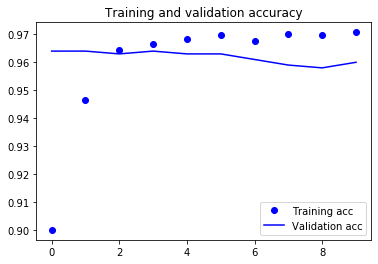

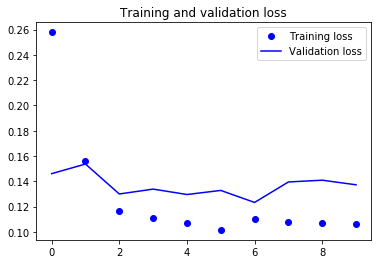

In [49]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

From the results, we can say that from the begining we are getting pretty good results. The training and validation accuracy curves oscillate in values greater than 0.95, and the same happens with the loss curves they go above values of 0.16. Maybe, we will be able to improve these results. Let's evaluate our model with our testing set.

In [50]:
scores = model.evaluate(x_test, y_test)
print('Test loss: ', scores[0])
print('Test accuracy: ', scores[1])

2690/2690 [==============================] - 2s 559us/sample - loss: 0.3055 - acc: 0.8658
Test loss:  0.30548404512795374
Test accuracy:  0.86579925


The testing loss and accuracy seem in high standings, nevertheless, we can try to understand better these results with the help of an Accuracy Analysis. Based on a binary classification confusion table, we will calculate precision and recall scores. In addition, based on the probabilites the model predict using the testing set, we will create a Receiver Operating Characteristics (ROC) curve and calculate the Area Under Curve (AUC). All of these operations can be easily done with sklearn metrics.

In [51]:
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, roc_curve, roc_auc_score

# Prediction
y_pred = model.predict(x_test) # probabilities
test_pred = np.where(y_pred >= 0.5, 1, 0) # classification

# True
test_true = y_test.values


# Confusion Matrix
print("Confusion Matrix\n")
print(confusion_matrix(test_true, test_pred))

Confusion Matrix

[[  67   48]
 [ 313 2262]]


From the confusion matrix we get 67 True Positives (TP) values, 48 False Negatives (FN), 313 False Positives (FP), and 2262 True Negatives (TN).

In [52]:
# precision tp / (tp + fp)
precision = precision_score(test_true, test_pred)
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(test_true, test_pred)
print('Recall: %f' % recall)


Precision: 0.979221
Recall: 0.878447


The percentage of Sensitivity(Recall) suggests that 87.84% of positive examples are correctly labeled, and the Precision suggests that 97.92% of the positive predictions are correct.

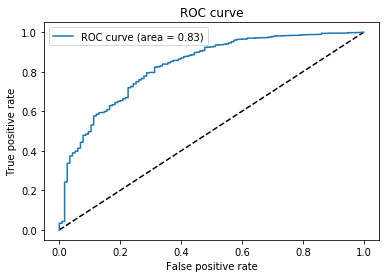

auc_score:  0.8290046433094133


In [54]:
# ROC_AUC_SCORE

auc_score = roc_auc_score(test_true, y_pred)

# ROC_CURVE

fpr, tpr, _ = roc_curve(test_true, y_pred)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

print('auc_score: ', auc_score)

Finally, our ROC curve tells us about the tradeoff between sensitivity (recall) and error. It is false positive rate vs true positive rate. The AUC of this curve is around 0.83.

### 2.2 Changing the architecture of the LSTM model

In this subsection, we will experiment with different model architectures, and tuning different parameters and hyperparameters to find a best model. 

This subsection presents some of the models we did while looking for our best model. Among the models are:

* Model 1: 32 neurons
* Model 2: 64 neurons
* Model 3: 128 neurons with dropout
* Model 4: 128 neurons, 2 LSTM layers, and dropout
* Model 5: 128 neurons, 2 LSTM layers, dropout, and changing learning rate
* Model 6: 128 neurons, 2 LSTM layers, dropout, and 2 dense layers

The results of the model do not change too much. However, considering loss, acc, val_loss, test_loss, test_acc, corresponding graphs, precision, recall and auc, we chose the `Model 4` as our best model. The parameter that really makes the difference is `auc`.

|Model     |acc     |val_acc |test_acc |roc_auc  |
|--------|---------|--------|----------|---------|
|Baseline  |0.9707  |0.9600  |0.8658   |0.8290  |
|Model 1   |0.9405  |0.9100  |0.7967   |0.8622  |
|Model 2   |0.9503  |0.9650  |0.9145   |0.8764  |
|Model 3   |0.9685  |0.9640  |0.9361   |0.8011  |
|**Model 4**   |0.9660  |0.9630  |0.9238  |**0.8929**  |
|Model 5   |0.9622  |0.9640  |0.9294  |0.8911  |
|Model 6   |0.9663  |0.9610  |0.9364  |0.8429  |

### Model (1): 32 neurons

In [35]:
model = Sequential()
model.add(layers.LSTM(32, input_shape=(None, x_train.shape[-1])))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=RMSprop(),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_split=0.2)

Train on 4000 samples, validate on 1000 samples
Epoch 1/10
4000/4000 [==============================] - 20s 5ms/sample - loss: 0.3600 - acc: 0.9183 - val_loss: 0.1515 - val_acc: 0.9620
Epoch 2/10
4000/4000 [==============================] - 19s 5ms/sample - loss: 0.1598 - acc: 0.9588 - val_loss: 0.1479 - val_acc: 0.9620
Epoch 3/10
4000/4000 [==============================] - 20s 5ms/sample - loss: 0.1526 - acc: 0.9622 - val_loss: 0.1447 - val_acc: 0.9630
Epoch 4/10
4000/4000 [==============================] - 21s 5ms/sample - loss: 0.1343 - acc: 0.9503 - val_loss: 0.1381 - val_acc: 0.9350
Epoch 5/10
4000/4000 [==============================] - 19s 5ms/sample - loss: 0.1003 - acc: 0.9572 - val_loss: 0.1439 - val_acc: 0.9310
Epoch 6/10
4000/4000 [==============================] - 19s 5ms/sample - loss: 0.1076 - acc: 0.9500 - val_loss: 0.1487 - val_acc: 0.9230
Epoch 7/10
4000/4000 [==============================] - 19s 5ms/sample - loss: 0.0976 - acc: 0.9590 - val_loss: 0.1604 - val_acc: 

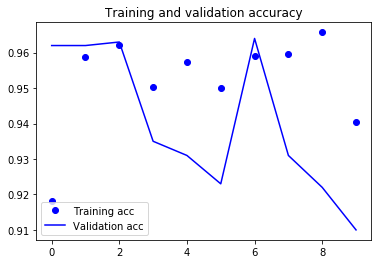

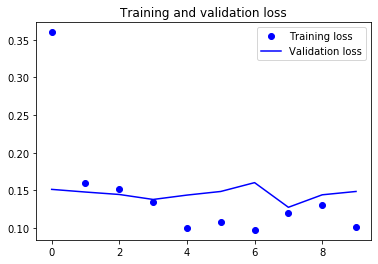

In [37]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [38]:
scores = model.evaluate(x_test, y_test)
print('Test loss: ', scores[0])
print('Test accuracy: ', scores[1])

2690/2690 [==============================] - 1s 340us/sample - loss: 0.2799 - acc: 0.7967
Test loss:  0.2799205402237775
Test accuracy:  0.7966543


In [40]:
# Prediction
y_pred = model.predict(x_test) # probabilities
test_pred = np.where(y_pred >= 0.5, 1, 0) # classification

# True
test_true = y_test.values


# Confusion Matrix
print("Confusion Matrix\n")
print(confusion_matrix(test_true, test_pred))

Confusion Matrix

[[  81   34]
 [ 513 2062]]


In [41]:
# precision tp / (tp + fp)
precision = precision_score(test_true, test_pred)
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(test_true, test_pred)
print('Recall: %f' % recall)


Precision: 0.983779
Recall: 0.800777


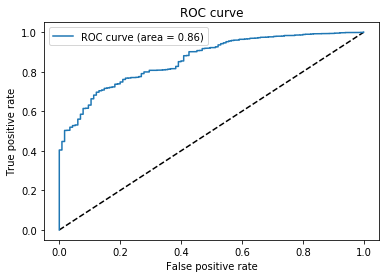

auc_score:  0.8621680033769522


In [47]:
# ROC_AUC_SCORE

auc_score_1 = roc_auc_score(test_true, y_pred)

# ROC_CURVE

fpr_1, tpr_1, _ = roc_curve(test_true, y_pred)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score_1)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

print('auc_score: ', auc_score_1)

### Model (2): 64 neurons


In [36]:
model = Sequential()
model.add(layers.LSTM(64, input_shape=(None, x_train.shape[-1])))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=RMSprop(),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_split=0.2)

Train on 4000 samples, validate on 1000 samples
Epoch 1/10
4000/4000 [==============================] - 24s 6ms/sample - loss: 0.2550 - acc: 0.9233 - val_loss: 0.1485 - val_acc: 0.9630
Epoch 2/10
4000/4000 [==============================] - 22s 6ms/sample - loss: 0.1526 - acc: 0.9615 - val_loss: 0.1467 - val_acc: 0.9640
Epoch 3/10
4000/4000 [==============================] - 25s 6ms/sample - loss: 0.1471 - acc: 0.9632 - val_loss: 0.1474 - val_acc: 0.9640
Epoch 4/10
4000/4000 [==============================] - 25s 6ms/sample - loss: 0.1218 - acc: 0.9503 - val_loss: 0.1529 - val_acc: 0.9220
Epoch 5/10
4000/4000 [==============================] - 26s 6ms/sample - loss: 0.1256 - acc: 0.9607 - val_loss: 0.1522 - val_acc: 0.9640
Epoch 6/10
4000/4000 [==============================] - 25s 6ms/sample - loss: 0.1358 - acc: 0.9690 - val_loss: 0.1490 - val_acc: 0.9650
Epoch 7/10
4000/4000 [==============================] - 27s 7ms/sample - loss: 0.1350 - acc: 0.9705 - val_loss: 0.1489 - val_acc: 

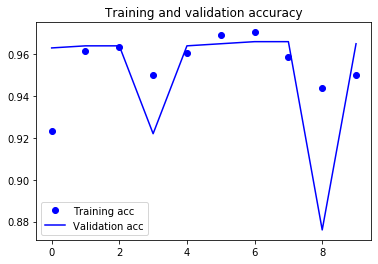

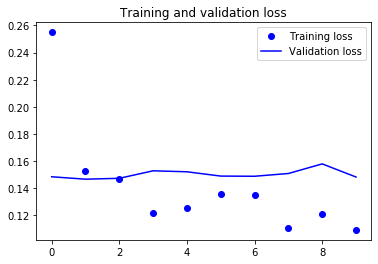

In [37]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [38]:
scores = model.evaluate(x_test, y_test)
print('Test loss: ', scores[0])
print('Test accuracy: ', scores[1])

2690/2690 [==============================] - 1s 406us/sample - loss: 0.2512 - acc: 0.9145
Test loss:  0.25123215712136054
Test accuracy:  0.91449815


In [39]:
# Prediction
y_pred = model.predict(x_test) # probabilities
test_pred = np.where(y_pred >= 0.5, 1, 0) # classification

# True
test_true = y_test.values


# Confusion Matrix
print("Confusion Matrix\n")
print(confusion_matrix(test_true, test_pred))

Confusion Matrix

[[  65   50]
 [ 180 2395]]


In [40]:
# precision tp / (tp + fp)
precision = precision_score(test_true, test_pred)
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(test_true, test_pred)
print('Recall: %f' % recall)


Precision: 0.979550
Recall: 0.930097


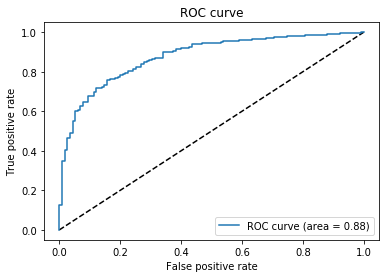

auc_score:  0.8763765301815112


In [42]:
# ROC_AUC_SCORE

auc_score_2 = roc_auc_score(test_true, y_pred)

# ROC_CURVE

fpr_2, tpr_2, _ = roc_curve(test_true, y_pred)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_2, tpr_2, label='ROC curve (area = %0.2f)' % auc_score_2)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

print('auc_score: ', auc_score_2)

### Model (3): 128 neuron, dropout 

In [69]:
model = Sequential()
model.add(layers.LSTM(128,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, x_train.shape[-1])))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=RMSprop(),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_split=0.2)

Train on 4000 samples, validate on 1000 samples
Epoch 1/10
4000/4000 [==============================] - 61s 15ms/sample - loss: 0.2382 - acc: 0.9215 - val_loss: 0.1563 - val_acc: 0.9620
Epoch 2/10
4000/4000 [==============================] - 57s 14ms/sample - loss: 0.1535 - acc: 0.9597 - val_loss: 0.1647 - val_acc: 0.9240
Epoch 3/10
4000/4000 [==============================] - 57s 14ms/sample - loss: 0.1487 - acc: 0.9582 - val_loss: 0.1471 - val_acc: 0.9650
Epoch 4/10
4000/4000 [==============================] - 57s 14ms/sample - loss: 0.1473 - acc: 0.9632 - val_loss: 0.1478 - val_acc: 0.9650
Epoch 5/10
4000/4000 [==============================] - 58s 14ms/sample - loss: 0.1408 - acc: 0.9600 - val_loss: 0.1757 - val_acc: 0.9040
Epoch 6/10
4000/4000 [==============================] - 60s 15ms/sample - loss: 0.1321 - acc: 0.9500 - val_loss: 0.1215 - val_acc: 0.9660
Epoch 7/10
4000/4000 [==============================] - 57s 14ms/sample - loss: 0.1152 - acc: 0.9668 - val_loss: 0.1470 - va

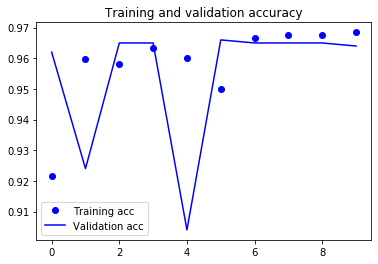

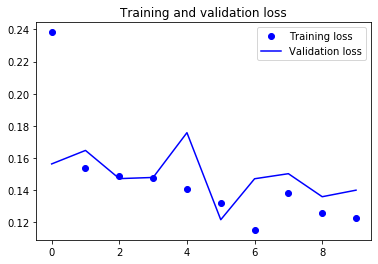

In [71]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [72]:
scores = model.evaluate(x_test, y_test)
print('Test loss: ', scores[0])
print('Test accuracy: ', scores[1])

2690/2690 [==============================] - 2s 582us/sample - loss: 0.2012 - acc: 0.9361
Test loss:  0.20118536780204027
Test accuracy:  0.9360595


In [73]:
# Prediction
y_pred = model.predict(x_test) # probabilities
test_pred = np.where(y_pred >= 0.5, 1, 0) # classification

# True
test_true = y_test.values


# Confusion Matrix
print("Confusion Matrix\n")
print(confusion_matrix(test_true, test_pred))

Confusion Matrix

[[  49   66]
 [ 106 2469]]


In [74]:
# precision tp / (tp + fp)
precision = precision_score(test_true, test_pred)
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(test_true, test_pred)
print('Recall: %f' % recall)


Precision: 0.973964
Recall: 0.958835


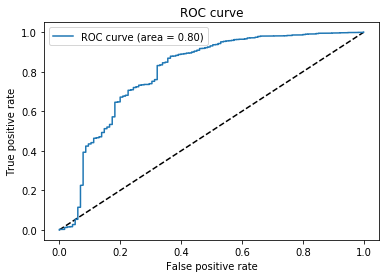

auc_score:  0.8011414098775854


In [77]:
# ROC_AUC_SCORE

auc_score_3 = roc_auc_score(test_true, y_pred)

# ROC_CURVE

fpr_3, tpr_3, _ = roc_curve(test_true, y_pred)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_3, tpr_3, label='ROC curve (area = %0.2f)' % auc_score_3)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

print('auc_score: ', auc_score_3)


### Model (4): 128 neuron, dropout, 2nd LSTM layer 

In [45]:
model = Sequential()
model.add(layers.LSTM(128,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, x_train.shape[-1])))
model.add(layers.LSTM(128,
                     dropout=0.1,
                     recurrent_dropout=0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=RMSprop(),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_split=0.2)

Train on 4000 samples, validate on 1000 samples
Epoch 1/10
4000/4000 [==============================] - 102s 26ms/sample - loss: 0.2246 - acc: 0.9255 - val_loss: 0.1675 - val_acc: 0.9640
Epoch 2/10
4000/4000 [==============================] - 103s 26ms/sample - loss: 0.1602 - acc: 0.9510 - val_loss: 0.1237 - val_acc: 0.9650
Epoch 3/10
4000/4000 [==============================] - 96s 24ms/sample - loss: 0.1441 - acc: 0.9585 - val_loss: 0.1348 - val_acc: 0.9650
Epoch 4/10
4000/4000 [==============================] - 95s 24ms/sample - loss: 0.1394 - acc: 0.9595 - val_loss: 0.1388 - val_acc: 0.9650
Epoch 5/10
4000/4000 [==============================] - 96s 24ms/sample - loss: 0.1306 - acc: 0.9620 - val_loss: 0.1267 - val_acc: 0.9600
Epoch 6/10
4000/4000 [==============================] - 95s 24ms/sample - loss: 0.1267 - acc: 0.9655 - val_loss: 0.1234 - val_acc: 0.9630
Epoch 7/10
4000/4000 [==============================] - 96s 24ms/sample - loss: 0.1180 - acc: 0.9657 - val_loss: 0.1292 - 

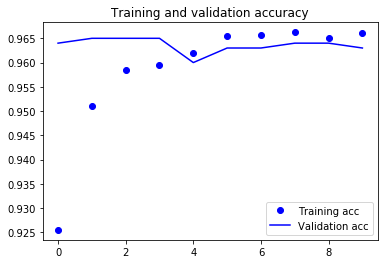

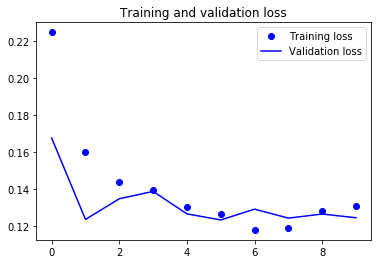

In [46]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [47]:
scores = model.evaluate(x_test, y_test)
print('Test loss: ', scores[0])
print('Test accuracy: ', scores[1])

2690/2690 [==============================] - 2s 865us/sample - loss: 0.2234 - acc: 0.9238
Test loss:  0.22337190138806198
Test accuracy:  0.9237918


In [48]:
# Prediction
y_pred = model.predict(x_test) # probabilities
test_pred = np.where(y_pred >= 0.5, 1, 0) # classification

# True
test_true = y_test.values


# Confusion Matrix
print("Confusion Matrix\n")
print(confusion_matrix(test_true, test_pred))

Confusion Matrix

[[  60   55]
 [ 150 2425]]


In [49]:
# precision tp / (tp + fp)
precision = precision_score(test_true, test_pred)
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(test_true, test_pred)
print('Recall: %f' % recall)


Precision: 0.977823
Recall: 0.941748


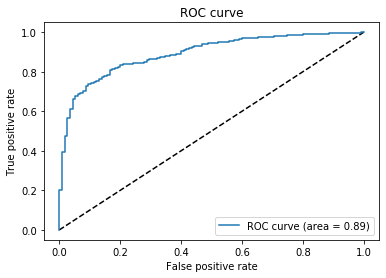

auc_score:  0.8919881806669481


In [52]:
# ROC_AUC_SCORE

auc_score_4 = roc_auc_score(test_true, y_pred)

# ROC_CURVE

fpr_4, tpr_4, _ = roc_curve(test_true, y_pred)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_4, tpr_4, label='ROC curve (area = %0.2f)' % auc_score_4)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

print('auc_score: ', auc_score_4)


### Model (5): 128 neuron, dropout, 2nd LSTM layer, lr: 1e-4

In [53]:
model = Sequential()
model.add(layers.LSTM(128,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, x_train.shape[-1])))
model.add(layers.LSTM(128,
                     dropout=0.1,
                     recurrent_dropout=0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=20,
                    validation_split=0.2)

Train on 4000 samples, validate on 1000 samples
Epoch 1/20
4000/4000 [==============================] - 103s 26ms/sample - loss: 0.6545 - acc: 0.9147 - val_loss: 0.5931 - val_acc: 0.9580
Epoch 2/20
4000/4000 [==============================] - 96s 24ms/sample - loss: 0.4019 - acc: 0.9510 - val_loss: 0.1567 - val_acc: 0.9610
Epoch 3/20
4000/4000 [==============================] - 97s 24ms/sample - loss: 0.1904 - acc: 0.9538 - val_loss: 0.1631 - val_acc: 0.9650
Epoch 4/20
4000/4000 [==============================] - 97s 24ms/sample - loss: 0.1823 - acc: 0.9535 - val_loss: 0.1591 - val_acc: 0.9650
Epoch 5/20
4000/4000 [==============================] - 96s 24ms/sample - loss: 0.1774 - acc: 0.9538 - val_loss: 0.1560 - val_acc: 0.9640
Epoch 6/20
4000/4000 [==============================] - 97s 24ms/sample - loss: 0.1702 - acc: 0.9567 - val_loss: 0.1563 - val_acc: 0.9640
Epoch 7/20
4000/4000 [==============================] - 98s 25ms/sample - loss: 0.1653 - acc: 0.9600 - val_loss: 0.1541 - v

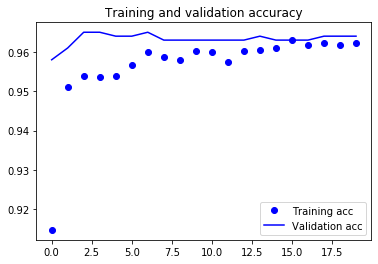

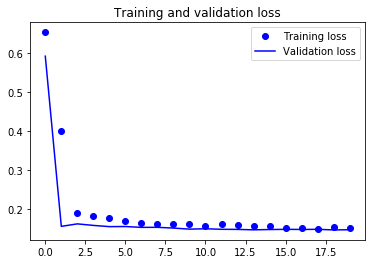

In [54]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [55]:
scores = model.evaluate(x_test, y_test)
print('Test loss: ', scores[0])
print('Test accuracy: ', scores[1])

2690/2690 [==============================] - 2s 912us/sample - loss: 0.1693 - acc: 0.9294
Test loss:  0.1693072997864516
Test accuracy:  0.929368


In [56]:
# Prediction
y_pred = model.predict(x_test) # probabilities
test_pred = np.where(y_pred >= 0.5, 1, 0) # classification

# True
test_true = y_test.values


# Confusion Matrix
print("Confusion Matrix\n")
print(confusion_matrix(test_true, test_pred))

Confusion Matrix

[[  57   58]
 [ 132 2443]]


In [57]:
# precision tp / (tp + fp)
precision = precision_score(test_true, test_pred)
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(test_true, test_pred)
print('Recall: %f' % recall)

Precision: 0.976809
Recall: 0.948738


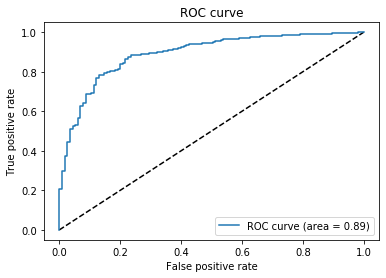

auc_score:  0.8911675812579147


In [59]:
# ROC_AUC_SCORE

auc_score_5 = roc_auc_score(test_true, y_pred)

# ROC_CURVE

fpr_5, tpr_5, _ = roc_curve(test_true, y_pred)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_5, tpr_5, label='ROC curve (area = %0.2f)' % auc_score_5)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

print('auc_score: ', auc_score_5)

### Model (6): 128 neuron, dropout, 2nd LSTM layer, 2-Dense Layers 

In [61]:
model = Sequential()
model.add(layers.LSTM(128,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, x_train.shape[-1])))
model.add(layers.LSTM(128,
                     dropout=0.1,
                     recurrent_dropout=0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=RMSprop(),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_split=0.2)

Train on 4000 samples, validate on 1000 samples
Epoch 1/10
4000/4000 [==============================] - 103s 26ms/sample - loss: 0.2205 - acc: 0.9243 - val_loss: 0.1535 - val_acc: 0.9600
Epoch 2/10
4000/4000 [==============================] - 97s 24ms/sample - loss: 0.1551 - acc: 0.9555 - val_loss: 0.1514 - val_acc: 0.9620
Epoch 3/10
4000/4000 [==============================] - 97s 24ms/sample - loss: 0.1554 - acc: 0.9592 - val_loss: 0.1520 - val_acc: 0.9630
Epoch 4/10
4000/4000 [==============================] - 97s 24ms/sample - loss: 0.1537 - acc: 0.9607 - val_loss: 0.1544 - val_acc: 0.9620
Epoch 5/10
4000/4000 [==============================] - 98s 25ms/sample - loss: 0.1544 - acc: 0.9607 - val_loss: 0.1579 - val_acc: 0.9630
Epoch 6/10
4000/4000 [==============================] - 98s 24ms/sample - loss: 0.1511 - acc: 0.9622 - val_loss: 0.1726 - val_acc: 0.9590
Epoch 7/10
4000/4000 [==============================] - 97s 24ms/sample - loss: 0.1451 - acc: 0.9632 - val_loss: 0.1544 - v

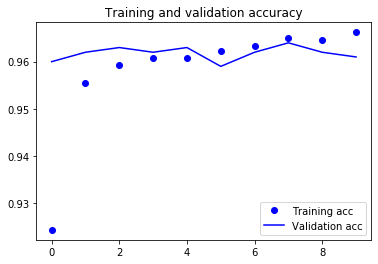

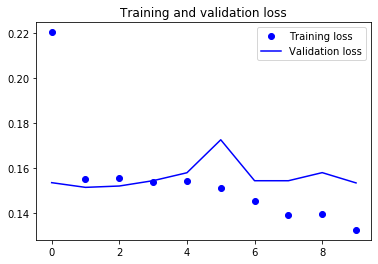

In [62]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [63]:
scores = model.evaluate(x_test, y_test)
print('Test loss: ', scores[0])
print('Test accuracy: ', scores[1])

2690/2690 [==============================] - 2s 906us/sample - loss: 0.2072 - acc: 0.9364
Test loss:  0.20715564749511756
Test accuracy:  0.9364312


In [64]:
# Prediction
y_pred = model.predict(x_test) # probabilities
test_pred = np.where(y_pred >= 0.5, 1, 0) # classification

# True
test_true = y_test.values


# Confusion Matrix
print("Confusion Matrix\n")
print(confusion_matrix(test_true, test_pred))

Confusion Matrix

[[  44   71]
 [ 100 2475]]


In [65]:
# precision tp / (tp + fp)
precision = precision_score(test_true, test_pred)
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(test_true, test_pred)
print('Recall: %f' % recall)


Precision: 0.972113
Recall: 0.961165


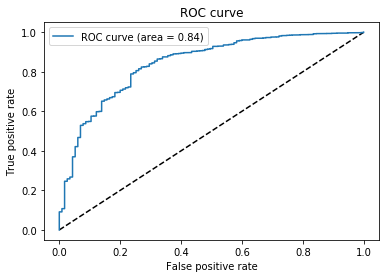

auc_score:  0.842880540312368


In [67]:
# ROC_AUC_SCORE

auc_score_6 = roc_auc_score(test_true, y_pred)

# ROC_CURVE

fpr_6, tpr_6, _ = roc_curve(test_true, y_pred)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_6, tpr_6, label='ROC curve (area = %0.2f)' % auc_score_6)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

print('auc_score: ', auc_score_6)


#### ROC curves - diferent neurons

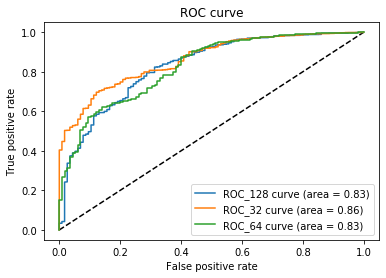

In [68]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='ROC_128 curve (area = %0.2f)' % auc_score)
plt.plot(fpr_1, tpr_1, label='ROC_32 curve (area = %0.2f)' % auc_score_1)
plt.plot(fpr_2, tpr_2, label='ROC_64 curve (area = %0.2f)' % auc_score_2)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


#### ROC curves model 4 and model 5

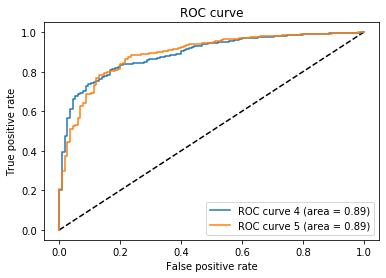

In [60]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_4, tpr_4, label='ROC curve 4 (area = %0.2f)' % auc_score_4)
plt.plot(fpr_5, tpr_5, label='ROC curve 5 (area = %0.2f)' % auc_score_5)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### 2.3 Changing the LSTM models to GRU models, and choosing best model

Now we are going to change the LSTM models to GRU models and choose our best model as we did in the last section.

This subsection presents some of the models we did while looking for our best GRU model. Among the models are:

* Model 1: GRU 32 neurons
* Model 2: GRU 64 neurons
* Model 3: GRU 128 neurons with dropout
* Model 4: 128 neurons, 2 GRU layers, and dropout
* Model 5: 128 neurons, 2 GRU layers, dropout, and changing learning rate
* Model 6: 128 neurons, 2 GRU layers, dropout, and 2 dense layers

The results of the model do not change too much. However, considering loss, acc, val_loss, test_loss, test_acc, precision, recall and auc, we chose the `Model 1` as our best model. The parameter that really makes the difference is `auc`.

|Model     |acc     |val_acc |test_acc|roc_auc   |
|----------|--------|--------|--------|----------|
|Baseline  |0.9690  |0.9650  |0.9457   |0.7973  |
|**Model 1**   |0.9670  |0.9660  |0.9353   |**0.8587**|
|Model 2   |0.9697  |0.9640  |0.9383   |0.8459  |
|Model 3   |0.9657  |0.9640  |0.9431   |0.8247  |
|Model 4   |0.9645  |0.9650  |0.9480   |0.8047  |
|Model 5   |0.9617  |0.9650  |0.9535   |0.8100  |
|Model 6   |0.9655  |0.9630  |0.9472   |0.7806 |

### Base-line

In [68]:
model = Sequential()
model.add(layers.GRU(128, input_shape=(None, x_train.shape[-1])))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=RMSprop(),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_split=0.2)

Train on 4000 samples, validate on 1000 samples
Epoch 1/10
4000/4000 [==============================] - 40s 10ms/sample - loss: 0.2842 - acc: 0.9260 - val_loss: 0.1495 - val_acc: 0.9640
Epoch 2/10
4000/4000 [==============================] - 38s 10ms/sample - loss: 0.1658 - acc: 0.9610 - val_loss: 0.1460 - val_acc: 0.9660
Epoch 3/10
4000/4000 [==============================] - 37s 9ms/sample - loss: 0.1555 - acc: 0.9622 - val_loss: 0.1516 - val_acc: 0.9640
Epoch 4/10
4000/4000 [==============================] - 37s 9ms/sample - loss: 0.1503 - acc: 0.9638 - val_loss: 0.1630 - val_acc: 0.9630
Epoch 5/10
4000/4000 [==============================] - 36s 9ms/sample - loss: 0.1482 - acc: 0.9645 - val_loss: 0.1609 - val_acc: 0.9650
Epoch 6/10
4000/4000 [==============================] - 37s 9ms/sample - loss: 0.1455 - acc: 0.9663 - val_loss: 0.1554 - val_acc: 0.9630
Epoch 7/10
4000/4000 [==============================] - 37s 9ms/sample - loss: 0.1421 - acc: 0.9672 - val_loss: 0.1782 - val_acc

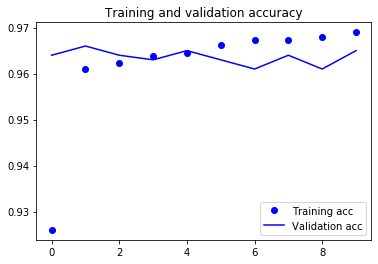

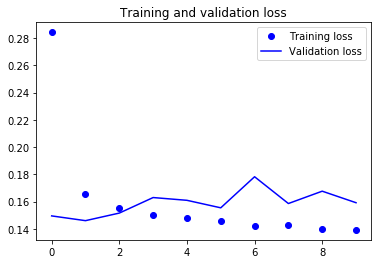

In [69]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [70]:
scores = model.evaluate(x_test, y_test)
print('Test loss: ', scores[0])
print('Test accuracy: ', scores[1])

2690/2690 [==============================] - 2s 575us/sample - loss: 0.2035 - acc: 0.9457
Test loss:  0.20346228003668076
Test accuracy:  0.9457249


In [71]:
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, roc_curve, roc_auc_score

# Prediction
y_pred = model.predict(x_test) # probabilities
test_pred = np.where(y_pred >= 0.5, 1, 0) # classification

# True
test_true = y_test.values


# Confusion Matrix
print("Confusion Matrix\n")
print(confusion_matrix(test_true, test_pred))

Confusion Matrix

[[  47   68]
 [  78 2497]]


In [72]:
# precision tp / (tp + fp)
precision = precision_score(test_true, test_pred)
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(test_true, test_pred)
print('Recall: %f' % recall)


Precision: 0.973489
Recall: 0.969709


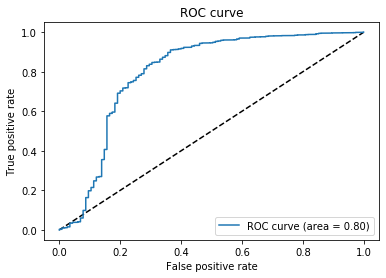

auc_score:  0.7972933727311101


In [74]:
# ROC_AUC_SCORE

auc_score_gru = roc_auc_score(test_true, y_pred)

# ROC_CURVE

fpr_gru, tpr_gru, _ = roc_curve(test_true, y_pred)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_gru, tpr_gru, label='ROC curve (area = %0.2f)' % auc_score_gru)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

print('auc_score: ', auc_score_gru)

### Model (1): 32 neurons

In [75]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, x_train.shape[-1])))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=RMSprop(),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_split=0.2)

Train on 4000 samples, validate on 1000 samples
Epoch 1/10
4000/4000 [==============================] - 22s 5ms/sample - loss: 0.4525 - acc: 0.9222 - val_loss: 0.1466 - val_acc: 0.9630
Epoch 2/10
4000/4000 [==============================] - 18s 5ms/sample - loss: 0.1652 - acc: 0.9580 - val_loss: 0.1443 - val_acc: 0.9630
Epoch 3/10
4000/4000 [==============================] - 18s 5ms/sample - loss: 0.1598 - acc: 0.9600 - val_loss: 0.1442 - val_acc: 0.9640
Epoch 4/10
4000/4000 [==============================] - 18s 5ms/sample - loss: 0.1547 - acc: 0.9617 - val_loss: 0.1469 - val_acc: 0.9650
Epoch 5/10
4000/4000 [==============================] - 19s 5ms/sample - loss: 0.1520 - acc: 0.9632 - val_loss: 0.1525 - val_acc: 0.9640
Epoch 6/10
4000/4000 [==============================] - 19s 5ms/sample - loss: 0.1501 - acc: 0.9640 - val_loss: 0.1478 - val_acc: 0.9650
Epoch 7/10
4000/4000 [==============================] - 20s 5ms/sample - loss: 0.1483 - acc: 0.9653 - val_loss: 0.1509 - val_acc: 

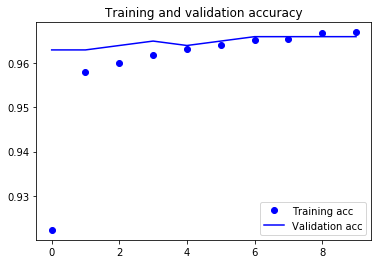

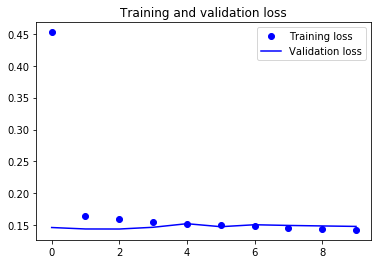

In [76]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [77]:
scores = model.evaluate(x_test, y_test)
print('Test loss: ', scores[0])
print('Test accuracy: ', scores[1])

2690/2690 [==============================] - 1s 404us/sample - loss: 0.1859 - acc: 0.9353
Test loss:  0.1858903120801573
Test accuracy:  0.93531597


In [78]:
# Prediction
y_pred = model.predict(x_test) # probabilities
test_pred = np.where(y_pred >= 0.5, 1, 0) # classification

# True
test_true = y_test.values


# Confusion Matrix
print("Confusion Matrix\n")
print(confusion_matrix(test_true, test_pred))

Confusion Matrix

[[  49   66]
 [ 108 2467]]


In [79]:
# precision tp / (tp + fp)
precision = precision_score(test_true, test_pred)
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(test_true, test_pred)
print('Recall: %f' % recall)


Precision: 0.973944
Recall: 0.958058


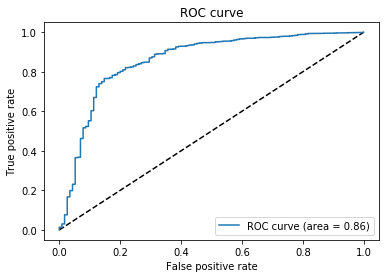

auc_score:  0.858682988602786


In [81]:
# ROC_AUC_SCORE

auc_score_gru_1 = roc_auc_score(test_true, y_pred)

# ROC_CURVE

fpr_gru_1, tpr_gru_1, _ = roc_curve(test_true, y_pred)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_gru_1, tpr_gru_1, label='ROC curve (area = %0.2f)' % auc_score_gru_1)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

print('auc_score: ', auc_score_gru_1)

### Model (2): 64 neurons


In [82]:
model = Sequential()
model.add(layers.GRU(64, input_shape=(None, x_train.shape[-1])))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=RMSprop(),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_split=0.2)

Train on 4000 samples, validate on 1000 samples
Epoch 1/10
4000/4000 [==============================] - 29s 7ms/sample - loss: 0.3344 - acc: 0.9250 - val_loss: 0.1587 - val_acc: 0.9620
Epoch 2/10
4000/4000 [==============================] - 24s 6ms/sample - loss: 0.1610 - acc: 0.9592 - val_loss: 0.1736 - val_acc: 0.9640
Epoch 3/10
4000/4000 [==============================] - 23s 6ms/sample - loss: 0.1558 - acc: 0.9600 - val_loss: 0.1475 - val_acc: 0.9640
Epoch 4/10
4000/4000 [==============================] - 25s 6ms/sample - loss: 0.1508 - acc: 0.9647 - val_loss: 0.1618 - val_acc: 0.9660
Epoch 5/10
4000/4000 [==============================] - 24s 6ms/sample - loss: 0.1493 - acc: 0.9645 - val_loss: 0.1526 - val_acc: 0.9640
Epoch 6/10
4000/4000 [==============================] - 24s 6ms/sample - loss: 0.1447 - acc: 0.9663 - val_loss: 0.1569 - val_acc: 0.9610
Epoch 7/10
4000/4000 [==============================] - 23s 6ms/sample - loss: 0.1414 - acc: 0.9678 - val_loss: 0.1529 - val_acc: 

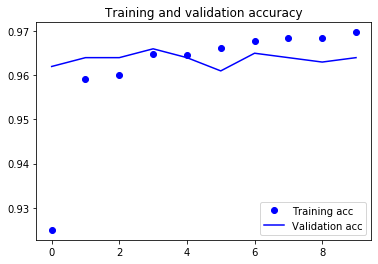

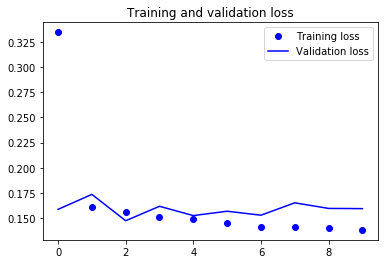

In [83]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [84]:
scores = model.evaluate(x_test, y_test)
print('Test loss: ', scores[0])
print('Test accuracy: ', scores[1])

2690/2690 [==============================] - 1s 410us/sample - loss: 0.2083 - acc: 0.9383
Test loss:  0.20826010850282406
Test accuracy:  0.93828994


In [85]:
# Prediction
y_pred = model.predict(x_test) # probabilities
test_pred = np.where(y_pred >= 0.5, 1, 0) # classification

# True
test_true = y_test.values


# Confusion Matrix
print("Confusion Matrix\n")
print(confusion_matrix(test_true, test_pred))

Confusion Matrix

[[  53   62]
 [ 104 2471]]


In [86]:
# precision tp / (tp + fp)
precision = precision_score(test_true, test_pred)
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(test_true, test_pred)
print('Recall: %f' % recall)


Precision: 0.975523
Recall: 0.959612


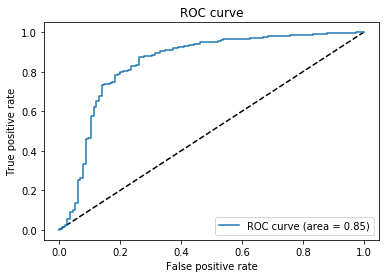

auc_score:  0.8459130434782609


In [88]:
# ROC_AUC_SCORE

auc_score_gru_2 = roc_auc_score(test_true, y_pred)

# ROC_CURVE

fpr_gru_2, tpr_gru_2, _ = roc_curve(test_true, y_pred)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_gru_2, tpr_gru_2, label='ROC curve (area = %0.2f)' % auc_score_gru_2)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

print('auc_score: ', auc_score_gru_2)

### Model (3): 128 neuron, dropout 

In [89]:
model = Sequential()
model.add(layers.GRU(128,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, x_train.shape[-1])))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=RMSprop(),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_split=0.2)

Train on 4000 samples, validate on 1000 samples
Epoch 1/10
4000/4000 [==============================] - 52s 13ms/sample - loss: 0.2924 - acc: 0.9215 - val_loss: 0.1681 - val_acc: 0.9620
Epoch 2/10
4000/4000 [==============================] - 49s 12ms/sample - loss: 0.1718 - acc: 0.9575 - val_loss: 0.1686 - val_acc: 0.9650
Epoch 3/10
4000/4000 [==============================] - 49s 12ms/sample - loss: 0.1621 - acc: 0.9597 - val_loss: 0.1534 - val_acc: 0.9610
Epoch 4/10
4000/4000 [==============================] - 50s 12ms/sample - loss: 0.1594 - acc: 0.9607 - val_loss: 0.1507 - val_acc: 0.9650
Epoch 5/10
4000/4000 [==============================] - 49s 12ms/sample - loss: 0.1527 - acc: 0.9620 - val_loss: 0.1635 - val_acc: 0.9630
Epoch 6/10
4000/4000 [==============================] - 49s 12ms/sample - loss: 0.1539 - acc: 0.9628 - val_loss: 0.1518 - val_acc: 0.9640
Epoch 7/10
4000/4000 [==============================] - 49s 12ms/sample - loss: 0.1539 - acc: 0.9628 - val_loss: 0.1573 - va

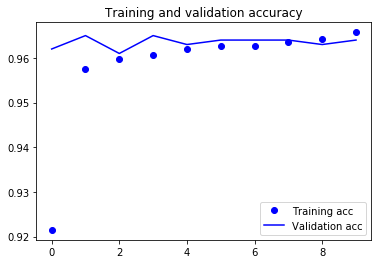

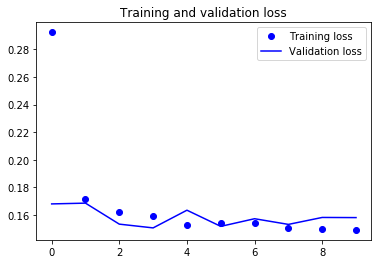

In [90]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [91]:
scores = model.evaluate(x_test, y_test)
print('Test loss: ', scores[0])
print('Test accuracy: ', scores[1])

2690/2690 [==============================] - 2s 595us/sample - loss: 0.2160 - acc: 0.9431
Test loss:  0.21603071764665466
Test accuracy:  0.9431227


In [92]:
# Prediction
y_pred = model.predict(x_test) # probabilities
test_pred = np.where(y_pred >= 0.5, 1, 0) # classification

# True
test_true = y_test.values


# Confusion Matrix
print("Confusion Matrix\n")
print(confusion_matrix(test_true, test_pred))

Confusion Matrix

[[  50   65]
 [  88 2487]]


In [93]:
# precision tp / (tp + fp)
precision = precision_score(test_true, test_pred)
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(test_true, test_pred)
print('Recall: %f' % recall)


Precision: 0.974530
Recall: 0.965825


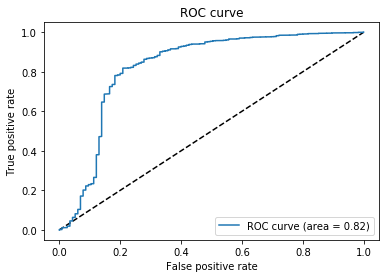

auc_score:  0.8247091599831152


In [95]:
# ROC_AUC_SCORE

auc_score_gru_3 = roc_auc_score(test_true, y_pred)

# ROC_CURVE

fpr_gru_3, tpr_gru_3, _ = roc_curve(test_true, y_pred)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_gru_3, tpr_gru_3, label='ROC curve (area = %0.2f)' % auc_score_gru_3)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

print('auc_score: ', auc_score_gru_3)


### Model (4): 128 neuron, dropout, 2nd GRU layer 

In [96]:
model = Sequential()
model.add(layers.GRU(128,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, x_train.shape[-1])))
model.add(layers.GRU(128,
                     dropout=0.1,
                     recurrent_dropout=0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=RMSprop(),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_split=0.2)

Train on 4000 samples, validate on 1000 samples
Epoch 1/10
4000/4000 [==============================] - 90s 22ms/sample - loss: 0.2579 - acc: 0.9218 - val_loss: 0.1554 - val_acc: 0.9630
Epoch 2/10
4000/4000 [==============================] - 84s 21ms/sample - loss: 0.1683 - acc: 0.9590 - val_loss: 0.1565 - val_acc: 0.9630
Epoch 3/10
4000/4000 [==============================] - 82s 20ms/sample - loss: 0.1622 - acc: 0.9595 - val_loss: 0.1553 - val_acc: 0.9620
Epoch 4/10
4000/4000 [==============================] - 82s 21ms/sample - loss: 0.1594 - acc: 0.9615 - val_loss: 0.1620 - val_acc: 0.9630
Epoch 5/10
4000/4000 [==============================] - 82s 21ms/sample - loss: 0.1583 - acc: 0.9610 - val_loss: 0.1632 - val_acc: 0.9640
Epoch 6/10
4000/4000 [==============================] - 82s 21ms/sample - loss: 0.1566 - acc: 0.9630 - val_loss: 0.1521 - val_acc: 0.9630
Epoch 7/10
4000/4000 [==============================] - 82s 20ms/sample - loss: 0.1535 - acc: 0.9615 - val_loss: 0.1556 - va

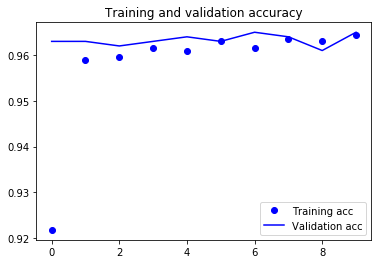

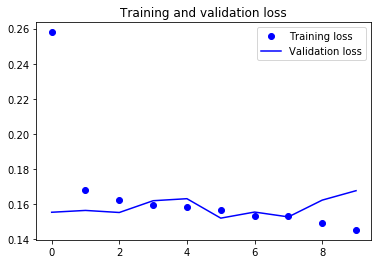

In [97]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [98]:
scores = model.evaluate(x_test, y_test)
print('Test loss: ', scores[0])
print('Test accuracy: ', scores[1])

2690/2690 [==============================] - 2s 844us/sample - loss: 0.2136 - acc: 0.9480
Test loss:  0.2135870107446129
Test accuracy:  0.94795537


In [99]:
# Prediction
y_pred = model.predict(x_test) # probabilities
test_pred = np.where(y_pred >= 0.5, 1, 0) # classification

# True
test_true = y_test.values


# Confusion Matrix
print("Confusion Matrix\n")
print(confusion_matrix(test_true, test_pred))

Confusion Matrix

[[  44   71]
 [  69 2506]]


In [100]:
# precision tp / (tp + fp)
precision = precision_score(test_true, test_pred)
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(test_true, test_pred)
print('Recall: %f' % recall)


Precision: 0.972449
Recall: 0.973204


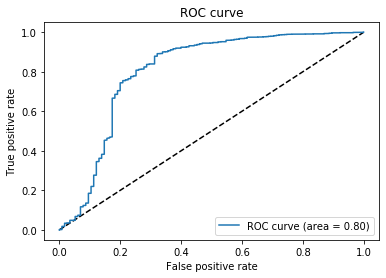

auc_score:  0.8046922752216125


In [102]:
# ROC_AUC_SCORE

auc_score_gru_4 = roc_auc_score(test_true, y_pred)

# ROC_CURVE

fpr_gru_4, tpr_gru_4, _ = roc_curve(test_true, y_pred)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_gru_4, tpr_gru_4, label='ROC curve (area = %0.2f)' % auc_score_gru_4)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

print('auc_score: ', auc_score_gru_4)


### Model (5): 128 neuron, dropout, 2nd GRU layer, lr: 1e-4

In [103]:
model = Sequential()
model.add(layers.GRU(128,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, x_train.shape[-1])))
model.add(layers.GRU(128,
                     dropout=0.1,
                     recurrent_dropout=0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=20,
                    validation_split=0.2)

Train on 4000 samples, validate on 1000 samples
Epoch 1/20
4000/4000 [==============================] - 88s 22ms/sample - loss: 0.6460 - acc: 0.9128 - val_loss: 0.5944 - val_acc: 0.9490
Epoch 2/20
4000/4000 [==============================] - 81s 20ms/sample - loss: 0.5346 - acc: 0.9470 - val_loss: 0.4387 - val_acc: 0.9610
Epoch 3/20
4000/4000 [==============================] - 81s 20ms/sample - loss: 0.3296 - acc: 0.9517 - val_loss: 0.2128 - val_acc: 0.9630
Epoch 4/20
4000/4000 [==============================] - 82s 20ms/sample - loss: 0.1953 - acc: 0.9560 - val_loss: 0.1677 - val_acc: 0.9630
Epoch 5/20
4000/4000 [==============================] - 82s 20ms/sample - loss: 0.1790 - acc: 0.9563 - val_loss: 0.1630 - val_acc: 0.9650
Epoch 6/20
4000/4000 [==============================] - 82s 20ms/sample - loss: 0.1758 - acc: 0.9565 - val_loss: 0.1597 - val_acc: 0.9630
Epoch 7/20
4000/4000 [==============================] - 82s 21ms/sample - loss: 0.1732 - acc: 0.9575 - val_loss: 0.1588 - va

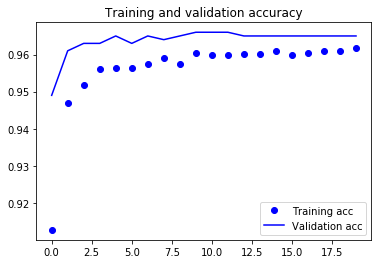

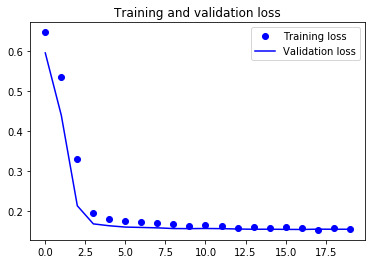

In [104]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [105]:
scores = model.evaluate(x_test, y_test)
print('Test loss: ', scores[0])
print('Test accuracy: ', scores[1])

2690/2690 [==============================] - 2s 897us/sample - loss: 0.1672 - acc: 0.9535
Test loss:  0.16721443210392636
Test accuracy:  0.9535316


In [106]:
# Prediction
y_pred = model.predict(x_test) # probabilities
test_pred = np.where(y_pred >= 0.5, 1, 0) # classification

# True
test_true = y_test.values


# Confusion Matrix
print("Confusion Matrix\n")
print(confusion_matrix(test_true, test_pred))

Confusion Matrix

[[  39   76]
 [  49 2526]]


In [107]:
# precision tp / (tp + fp)
precision = precision_score(test_true, test_pred)
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(test_true, test_pred)
print('Recall: %f' % recall)

Precision: 0.970792
Recall: 0.980971


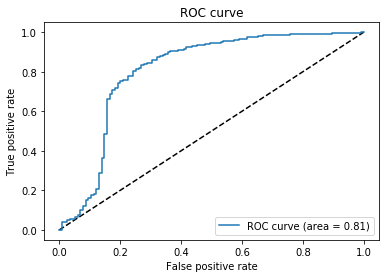

auc_score:  0.8062068383284084


In [109]:
# ROC_AUC_SCORE

auc_score_gru_5 = roc_auc_score(test_true, y_pred)

# ROC_CURVE

fpr_gru_5, tpr_gru_5, _ = roc_curve(test_true, y_pred)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_gru_5, tpr_gru_5, label='ROC curve (area = %0.2f)' % auc_score_gru_5)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

print('auc_score: ', auc_score_gru_5)

### Model (6): 128 neuron, dropout, 2nd GRU layer, 2-Dense Layers

In [110]:
model = Sequential()
model.add(layers.GRU(128,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, x_train.shape[-1])))
model.add(layers.GRU(128,
                     dropout=0.1,
                     recurrent_dropout=0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=RMSprop(),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_split=0.2)

Train on 4000 samples, validate on 1000 samples
Epoch 1/10
4000/4000 [==============================] - 91s 23ms/sample - loss: 0.2392 - acc: 0.9280 - val_loss: 0.1723 - val_acc: 0.9650
Epoch 2/10
4000/4000 [==============================] - 82s 21ms/sample - loss: 0.1722 - acc: 0.9578 - val_loss: 0.1947 - val_acc: 0.9670
Epoch 3/10
4000/4000 [==============================] - 81s 20ms/sample - loss: 0.1643 - acc: 0.9600 - val_loss: 0.1508 - val_acc: 0.9640
Epoch 4/10
4000/4000 [==============================] - 81s 20ms/sample - loss: 0.1592 - acc: 0.9603 - val_loss: 0.1544 - val_acc: 0.9650
Epoch 5/10
4000/4000 [==============================] - 82s 20ms/sample - loss: 0.1562 - acc: 0.9617 - val_loss: 0.1656 - val_acc: 0.9640
Epoch 6/10
4000/4000 [==============================] - 81s 20ms/sample - loss: 0.1559 - acc: 0.9628 - val_loss: 0.1603 - val_acc: 0.9630
Epoch 7/10
4000/4000 [==============================] - 81s 20ms/sample - loss: 0.1504 - acc: 0.9643 - val_loss: 0.1602 - va

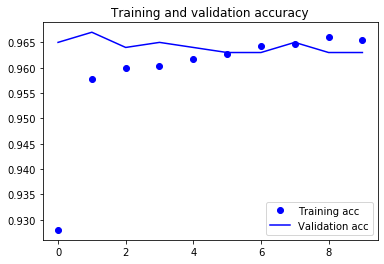

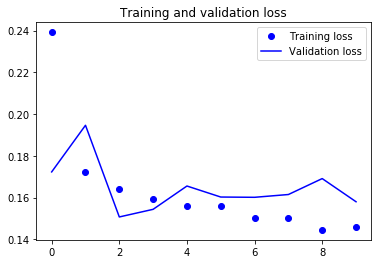

In [111]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [112]:
scores = model.evaluate(x_test, y_test)
print('Test loss: ', scores[0])
print('Test accuracy: ', scores[1])

2690/2690 [==============================] - 2s 894us/sample - loss: 0.1924 - acc: 0.9472
Test loss:  0.19238387895228695
Test accuracy:  0.9472119


In [113]:
# Prediction
y_pred = model.predict(x_test) # probabilities
test_pred = np.where(y_pred >= 0.5, 1, 0) # classification

# True
test_true = y_test.values


# Confusion Matrix
print("Confusion Matrix\n")
print(confusion_matrix(test_true, test_pred))

Confusion Matrix

[[  36   79]
 [  63 2512]]


In [114]:
# precision tp / (tp + fp)
precision = precision_score(test_true, test_pred)
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(test_true, test_pred)
print('Recall: %f' % recall)


Precision: 0.969510
Recall: 0.975534


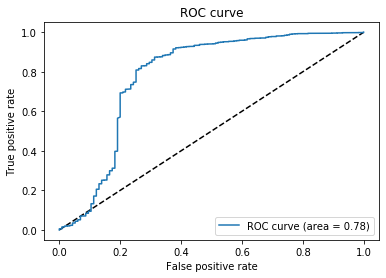

auc_score:  0.7805859012241453


In [116]:
# ROC_AUC_SCORE

auc_score_gru_6 = roc_auc_score(test_true, y_pred)

# ROC_CURVE

fpr_gru_6, tpr_gru_6, _ = roc_curve(test_true, y_pred)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_gru_6, tpr_gru_6, label='ROC curve (area = %0.2f)' % auc_score_gru_6)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

print('auc_score: ', auc_score_gru_6)


#### ROC curves for all GRU models

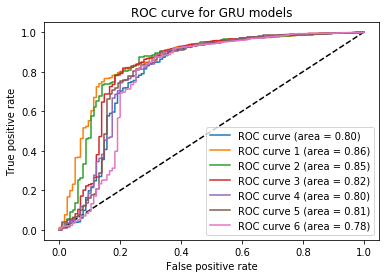

In [119]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_gru, tpr_gru, label='ROC curve (area = %0.2f)' % auc_score_gru)
plt.plot(fpr_gru_1, tpr_gru_1, label='ROC curve 1 (area = %0.2f)' % auc_score_gru_1)
plt.plot(fpr_gru_2, tpr_gru_2, label='ROC curve 2 (area = %0.2f)' % auc_score_gru_2)
plt.plot(fpr_gru_3, tpr_gru_3, label='ROC curve 3 (area = %0.2f)' % auc_score_gru_3)
plt.plot(fpr_gru_4, tpr_gru_4, label='ROC curve 4 (area = %0.2f)' % auc_score_gru_4)
plt.plot(fpr_gru_5, tpr_gru_5, label='ROC curve 5 (area = %0.2f)' % auc_score_gru_5)
plt.plot(fpr_gru_6, tpr_gru_6, label='ROC curve 6 (area = %0.2f)' % auc_score_gru_6)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for GRU models')
plt.legend(loc='best')
plt.show()

### Comparing Results

|Model    |acc     |val_acc |test_acc|auc  |
|---------|--------|--------|--------|-------|
|**Model 1 GRU**   |0.9670  |0.9660  |0.9581  |0.8587  |
|**Model 4 LSTM**  |0.9660  |0.9630  |0.9417  |0.8929  |

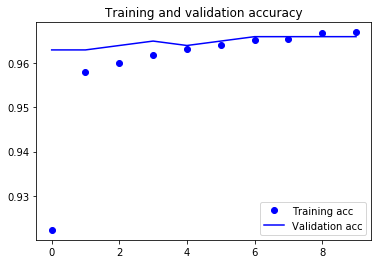

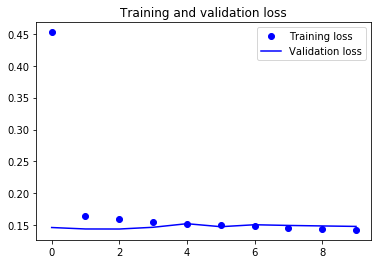

In [76]:
### Model 1 GRU ###

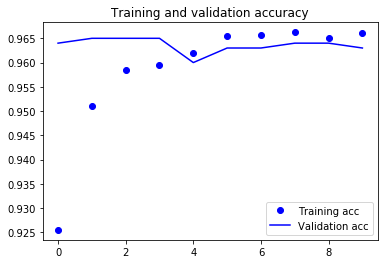

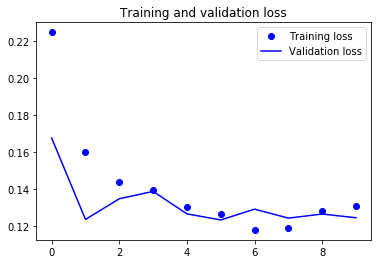

In [46]:
## Model 4 LSTM ##

The results from both models are similar, this could de due to the fact that both RNN models (LSTM, and GRU) work fine with timesequence. The best model we selected among the GRU's is the `Model 1`, we reached our best model just by reducing some neurons from the base-line, it is important to remember that GRU units work under the concept of LSTM, however, doing a trade-off between computational expensiveness and representational power, so the GRU model is using less resources to get to a efficient solution. At the same time, the LSTM graph seems to have reduced as much as possible overfitting and it acquires a greater ROC_AUC.